In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from collections import Counter
import matplotlib
import os
from scipy.stats import pearsonr
from scipy.spatial.distance import braycurtis
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statannot import add_stat_annotation
from scipy.stats import spearmanr
%matplotlib inline
from Bio import SeqIO

# Read taxonomy

In [2]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,394eda29c886632f514dd94b58381186,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,1.000000,f__Pasteurellaceae
1,06f825b512d903b9230e1a55d87359ee,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.997372,g__Streptococcus
2,923f521b9cf313f1f95c9367e09bbc1c,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.999995,g__Veillonella
3,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
4,4f5efd25dacb5d639316e7291ff6ff8b,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.997145,g__Neisseria


# Read metadata

In [3]:
df_meta = pd.read_csv("qiime2_output/SraRunTable.csv", index_col=0)
df_meta = df_meta[['env_medium','Host_disease','Library Name','Sample Name']]
df_meta.columns = ['BodySite','HostDisease','LibraryName','SampleName']
df_meta['SubjectID'] = [x.replace('Gut','HC').replace('Mouth','HC') if x.startswith('Gut') or x.startswith('Mouth') 
                        else x.replace('Gut','').replace('Mouth','') for x in df_meta.LibraryName]
df_meta['SubjectID'] = [x.replace('_','_0') if len(x.split('_')[1])==1 else x for x in df_meta['SubjectID']]
df_meta.index.name = 'SampleID'
df_meta['Disease'] = [x.split('_')[0] for x in df_meta.SubjectID]
df_meta.head()

,BodySite,HostDisease,LibraryName,SampleName,SubjectID,Disease
SampleID,,,,,,
SRR13302275,stool,periodontitis positive,CDGut_8,JI0168,CD_08,CD
SRR13302276,stool,periodontitis positive,CDGut_9,JI0170,CD_09,CD
SRR13302277,stool,periodontitis positive,CDGut_10,JI0171,CD_10,CD
SRR13302278,stool,periodontitis negative,CDGut_11,JI0172,CD_11,CD
SRR13302279,stool,periodontitis positive,CDGut_12,JI0173,CD_12,CD


In [4]:
set(df_meta.Disease)

{'CD', 'HC', 'UC'}

# Read count data (filter out samples with less than 1000 reads)

In [5]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 1088


#OTU ID,394eda29c886632f514dd94b58381186,06f825b512d903b9230e1a55d87359ee,923f521b9cf313f1f95c9367e09bbc1c,99deb3c5ecb022ec05609ebd1112a557,4f5efd25dacb5d639316e7291ff6ff8b,32f8fd11d2bee278d609a1d4ab767554,cd9401a6bce4a63af516d06d2a843f9d,d46e2205f0c6ecf67b51f83d111c509c,c6c3ab4e828fb40d6e05967b7aac9338,ca9c66d47347c03d0343d6fe03ed8636,...,3a182b5e7d0fcf5b1025e34c0a963e09,0b24027ea459399918ba5f4296ada9b4,1bcbd595fc80dafe064edfdfcae08fb8,eca538e0b9b601dfea22437417fec434,acccb7cec4d146864bc11d37da55dcd0,650aeb6747ae34ac802b446b5b149044,989a083f922229dd6b663ba46b1c9dc7,e13020761747ff138510eba6730461d0,f2d1ad47ff53d32e9a37aa2abaacc3ff,7eb40e9c821a22760e633a88b40d5939
SRR13261749,0.139797,0.090749,0.064673,0.000000,0.016970,0.041908,0.042425,0.000000,0.000000,0.042736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13302359,0.000000,0.000000,0.000000,0.193878,0.000000,0.000000,0.000000,0.002172,0.044108,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13302306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002150,0.024626,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13261740,0.093133,0.033474,0.037245,0.000000,0.059994,0.122544,0.077506,0.000000,0.000000,0.021786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13302354,0.000356,0.000000,0.000000,0.084799,0.000000,0.000000,0.000000,0.015268,0.040997,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compare different oral fraction estimation methods

In [6]:
df_blast_HOMD = pd.read_csv("qiime2_output/asv-sequences/blast_HOMD/blast_HOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_HOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_fHOMD = pd.read_csv("qiime2_output/asv-sequences/blast_fHOMD/blast_fHOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_fHOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [7]:
all_subjects = list(set(df_meta.SubjectID))
res = []
for sub in all_subjects:
    curr_df = df_meta[df_meta.SubjectID==sub]
    gut_sample_id = list(curr_df[curr_df.BodySite=='stool'].index)
    assert len(gut_sample_id) == 1
    gut_sample_id = gut_sample_id[0]
    oral_sample_id = list(curr_df[curr_df.BodySite=='saliva'].index)
    assert len(oral_sample_id)==1
    oral_sample_id = oral_sample_id[0]
    
    if gut_sample_id not in list(df_relabun.index) or oral_sample_id not in list(df_relabun.index):
        continue
        
    disease = list(curr_df.Disease)[0]
    
    # oral sequences
    df_oral_seqs = df_relabun.loc[oral_sample_id]
    oral_seqs = list(df_oral_seqs[df_oral_seqs>1e-3].index)
    
    # HOMD, all hits
    HOMD_hit = set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HOMD = df_relabun.loc[gut_sample_id, HOMD_hit].sum()
    
    # HOMD, hits present in oral cavity
    oral_seqs_w_HOMD_hit = set(oral_seqs).intersection(set(df_blast_HOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HOMD_hit].sum()
    
    # fHOMD, all hits
    fHOMD_hit = set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns))
    oral_frac_fHOMD = df_relabun.loc[gut_sample_id, fHOMD_hit].sum()
    
    # fHOMD, hits present in oral cavity
    oral_seqs_w_fHOMD_hit = set(oral_seqs).intersection(set(df_blast_fHOMD.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_fHOMD_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_fHOMD_hit].sum()
    
    # HMPv35oral, all hits
    HMPv35oral_hit = set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns))
    oral_frac_HMPv35oral = df_relabun.loc[gut_sample_id, HMPv35oral_hit].sum()
    
    # HMPv35oral, hits present in oral cavity
    oral_seqs_w_HMPv35oral_hit = set(oral_seqs).intersection(set(df_blast_HMPv35oral.query_accver).intersection(set(df_relabun.columns)))
    oral_frac_HMPv35oral_overlap = df_relabun.loc[gut_sample_id, oral_seqs_w_HMPv35oral_hit].sum()
    
    if oral_frac_HOMD==0:
        res.append([gut_sample_id, 'HOMD', oral_frac_HOMD, 1.0, disease])
    else:
        res.append([gut_sample_id, 'HOMD', oral_frac_HOMD, oral_frac_HOMD_overlap/oral_frac_HOMD, disease])
        
    if oral_frac_fHOMD==0:
        res.append([gut_sample_id, 'fHOMD', oral_frac_fHOMD, 1.0, disease])
    else:
        res.append([gut_sample_id, 'fHOMD', oral_frac_fHOMD, oral_frac_fHOMD_overlap/oral_frac_fHOMD, disease])
        
    if oral_frac_HMPv35oral==0:
        res.append([gut_sample_id, 'HMPv35oral', oral_frac_HMPv35oral, 1.0, disease])
    else:
        res.append([gut_sample_id, 'HMPv35oral', oral_frac_HMPv35oral, oral_frac_HMPv35oral_overlap/oral_frac_HMPv35oral, disease])

df_res = pd.DataFrame(res, columns=['SampleID','Method','OralFrac','FracInOralSample','Disease']).set_index('SampleID')
df_res.head()

,Method,OralFrac,FracInOralSample,Disease
SampleID,,,,
SRR13302321,HOMD,0.038321,0.535316,HC
SRR13302321,fHOMD,0.000617,1.000000,HC
SRR13302321,HMPv35oral,0.019327,1.000000,HC
SRR13302341,HOMD,0.017456,0.184932,HC
SRR13302341,fHOMD,0.000000,1.000000,HC


In [8]:
Counter(df_meta.loc[df_res.index].Disease)

Counter({'HC': 129, 'CD': 48, 'UC': 126})

In [9]:
len(set(df_res.index))

101

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


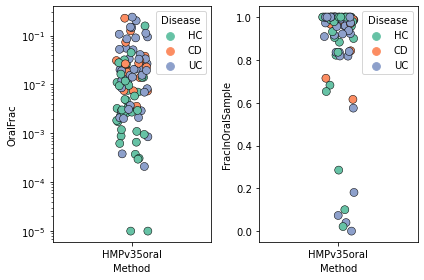

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,4))

# oral bacterial fraction
df2plot = df_res[df_res.Method=='HMPv35oral']
df2plot.loc[df2plot.OralFrac == 0, 'OralFrac'] = 1e-5
_ = sns.stripplot(x="Method", y="OralFrac", data=df2plot, ax=ax[0], s=8, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)
_ = ax[0].set_yscale('log')

# percentage of fraction present in the oral cavity
df2plot = df2plot[df2plot.OralFrac > 1e-4]
_ = sns.stripplot(x="Method", y="FracInOralSample", data=df2plot, ax=ax[1], s=8, edgecolor='k', linewidth=0.5, palette='Set2', hue='Disease', hue_order=['HC','CD','UC'], jitter=True)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("IBD_oral_bacteria_fraction_in_stool.svg", dpi=600, bbox_inches='tight')

In [11]:
df_res[(df_res.Disease=='HC') & (df_res.Method=='HMPv35oral')].OralFrac.mean()

0.011387985142254297

In [12]:
df_res[(df_res.Disease=='CD') & (df_res.Method=='HMPv35oral')].OralFrac.mean()

0.04214400762028497

In [13]:
df_res[(df_res.Disease=='UC') & (df_res.Method=='HMPv35oral')].OralFrac.mean()

0.04270553749180793

In [23]:
df_res[df_res.Method=='HMPv35oral'][df_res[df_res.Method=='HMPv35oral'].FracInOralSample>=0.85]

,Method,OralFrac,FracInOralSample,Disease
SampleID,,,,
SRR13302321,HMPv35oral,0.019327,1.0,HC
SRR13302341,HMPv35oral,0.003228,1.0,HC
SRR13302355,HMPv35oral,0.006962,1.0,HC
SRR13302339,HMPv35oral,0.023354,1.0,HC
SRR13302282,HMPv35oral,0.013777,1.0,CD
...,...,...,...,...
SRR13302298,HMPv35oral,0.004935,1.0,HC
SRR13302312,HMPv35oral,0.003009,1.0,HC
SRR13302362,HMPv35oral,0.003078,1.0,UC


In [65]:
# fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,12), sharex=True, sharey=True)

# #Create a matplotlib colormap from the sns purple color palette
# cmap    = sns.light_palette("purple", reverse=True, as_cmap=True )
# # Normalize to the range of possible values from df["c"]
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# # create a color dictionary (value in c : color from colormap) 
# colors = {}
# for cval in df_res.FracInOralSample:
#     colors.update({cval : cmap(norm(cval))})
    
# for k,d in enumerate(['HC','CD','UC']):
#     _ = sns.stripplot(x="Method", y="OralFrac", data=df_res[df_res.Disease==d], ax=ax[k], order=['HOMD','fHOMD','HMPv35oral'], size=6, 
#                       hue='FracInOralSample', palette = colors, s=6, edgecolor='k', linewidth=0.5)
#     _ = ax[k].legend_.remove()
#     _ = ax[k].set_yscale('log')
#     _ = ax[k].set_ylim([2e-4,2])
# divider = make_axes_locatable(plt.gca())
# ax_cb = divider.new_horizontal(size="5%", pad=0.05)
# fig.add_axes(ax_cb)
# cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
#                                 norm=norm,
#                                 orientation='vertical')
# cb1.set_label('Fraction present in oral cavity')

# plt.tight_layout()
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("compare_oral_estimation_methods.svg", dpi=600, bbox_inches='tight')

## Correlate oral bacterial fraction and sequencing depth

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


SpearmanrResult(correlation=0.3956330682400824, pvalue=4.222522209762245e-05)


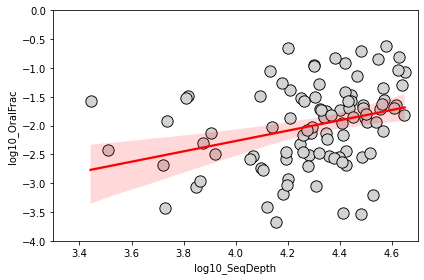

In [66]:
# compute sequence depth
df_count_sum = pd.merge(df_meta[df_meta.BodySite=='stool'], df_count.sum(axis=1).to_frame().rename({0:'SeqDepth'}, axis=1), left_index=True, right_index=True, how='inner')
df_count_sum = pd.merge(df_count_sum, df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1),
                        left_index=True, right_index=True, how='inner')
df_count_sum = df_count_sum.loc[set(df_res.index)]
df_count_sum['log10_SeqDepth'] = np.log10(df_count_sum['SeqDepth'])
df_count_sum['log10_OralFrac'] = np.log10(df_count_sum['OralFrac'])

# spearman correlation
print(spearmanr(df_count_sum.SeqDepth, df_count_sum.OralFrac))

fig, ax = plt.subplots(figsize=(6,4))
_ = sns.scatterplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, s=128, color='lightgray', edgecolor='k')
_ = sns.regplot(x="log10_SeqDepth", y="log10_OralFrac", data=df_count_sum[df_count_sum.OralFrac>0], ax=ax, scatter=False, color="red")
_ = ax.set_ylim([-4,-0])
_ = ax.set_xlim([3.3,4.7])
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatterplot_depth_vs_oral_fraction.svg", dpi=600, bbox_inches='tight')

# Plot oral bacterial enrichment in CD and UC patients

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HC v.s. CD: Kruskal-Wallis paired samples, P_val=8.197e-05 stat=1.551e+01
HC v.s. UC: Kruskal-Wallis paired samples, P_val=9.512e-05 stat=1.523e+01


/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


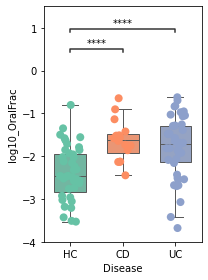

In [67]:
fig, ax = plt.subplots(figsize=(3,4))
df2plot = pd.merge(df_meta, df_res[df_res.Method=='HMPv35oral'].drop('Disease',axis=1), left_index=True, right_index=True, how='inner')
df2plot['log10_OralFrac'] = np.log10(df2plot['OralFrac'])

_ = sns.boxplot(y="log10_OralFrac", x="Disease", data=df2plot, width=.6, ax=ax, order=['HC','CD','UC'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="log10_OralFrac", x="Disease", data=df2plot, size=8, color=".3", linewidth=0, ax=ax, jitter=0.2, palette='Set2', dodge=True, order=['HC','CD','UC'])
_ = add_stat_annotation(ax, data=df2plot, y="OralFrac", x="Disease", order=['HC','CD','UC'],
                        comparisons_correction=None,
                        box_pairs=[("HC","CD"),("HC","UC")],
                        test='Kruskal', text_format='star', loc='inside', verbose=1)
_ = ax.set_ylim([-4,1.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("oral_enrichment_in_IBD.svg", dpi=600)

# Show changes in oral bacterial fraction at more stringent criteria

In [104]:
df_blast_HMPv35 = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35/blast_HMPv35_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [105]:
df_cutoff = pd.read_csv("../../build_human_reference_database/oral_typical_seqs_vary_cutoffs.csv", index_col=0)
df_cutoff.head()

,"1.00e-04, 5.00e-02, 1.00e-04","1.00e-04, 5.00e-02, 1.00e-03","1.00e-04, 1.00e-01, 1.00e-04","1.00e-04, 1.00e-01, 1.00e-03","1.00e-03, 5.00e-02, 1.00e-04","1.00e-03, 5.00e-02, 1.00e-03","1.00e-03, 1.00e-01, 1.00e-04","1.00e-03, 1.00e-01, 1.00e-03"
#OTU ID,,,,,,,,
0096a273ac0abbb04557fff40774244c,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0863adf64994d46f2342303cdd22bde9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
08a4d4e95b0f4a7f11cd17b916fc366b,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
0936f17723be73c6e5220d3bb175d53b,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
0c26d5527a0f5dd2c2701bb297ac96b9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
df_oral_fracs = None
for col in df_cutoff.columns:
    relabun_cutoff = float(col.split(', ')[0])
    prevalence_cutoff = float(col.split(', ')[1])
    hmp_oral_typical = list(df_cutoff[df_cutoff[col]==1].index)
    hits = set(df_blast_HMPv35[df_blast_HMPv35.subject_accver.isin(hmp_oral_typical)].query_accver).intersection(set(df_relabun.columns))
    oral_fracs = df_relabun.loc[set(df_meta[df_meta.BodySite=='stool'].index).intersection(set(df_relabun.index)), hits].sum(axis=1).to_frame().rename({0:col}, axis=1)
    if df_oral_fracs is None:
        df_oral_fracs = deepcopy(oral_fracs)
    else:
        df_oral_fracs = pd.merge(df_oral_fracs, oral_fracs, left_index=True, right_index=True, how='inner')
df_oral_fracs = pd.merge(df_oral_fracs, df_meta[['Disease']], left_index=True, right_index=True, how='left').sort_values('Disease')
df_oral_fracs.columns = [(',').join(['%s%%' % str(float(x)*100) for x in col.split(', ')]) if col != 'Disease' else 'Disease' for col in df_oral_fracs.columns]
df_oral_fracs.head()

,"0.01%,5.0%,0.01%","0.01%,5.0%,0.1%","0.01%,10.0%,0.01%","0.01%,10.0%,0.1%","0.1%,5.0%,0.01%","0.1%,5.0%,0.1%","0.1%,10.0%,0.01%","0.1%,10.0%,0.1%",Disease
SRR13302346,0.016925,0.030218,0.028822,0.028822,0.014970,0.028263,0.028263,0.028263,CD
SRR13302278,0.121363,0.124549,0.084980,0.084980,0.169657,0.172844,0.133275,0.133275,CD
SRR13302299,0.021930,0.026344,0.025231,0.025231,0.021678,0.026093,0.026093,0.026093,CD
SRR13302281,0.001994,0.003574,0.003574,0.003574,0.003085,0.004664,0.004664,0.004664,CD
SRR13302350,0.055862,0.072951,0.072032,0.072032,0.101341,0.118430,0.118430,0.118430,CD


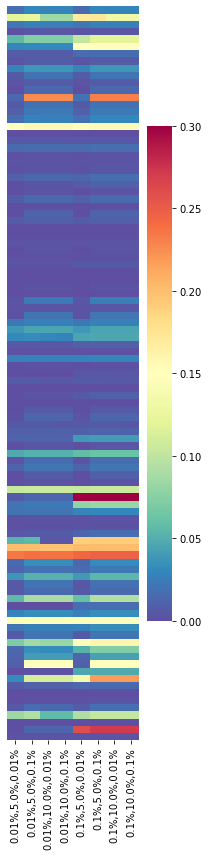

In [135]:
fig, ax = plt.subplots(figsize=(3,12))

# change relative abundance
_ = sns.heatmap(
    df_oral_fracs.iloc[:,0:-1],
    vmin=0,
    vmax=0.3,
    cmap='Spectral_r',
    yticklabels=False,
    ax=ax
)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("oral_enrichment_in_IBD.svg", dpi=600)

In [109]:
Counter(df_oral_fracs.Disease)

Counter({'CD': 16, 'HC': 43, 'UC': 42})